In [1]:
######this is structured according to @karpathy with additional functionality for novices like myself. tysm.######### 

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#1- we will use Elliptic curve cruptograph instead of RSA



In [5]:
#encryption by RSA

word = "CLOUD"
int_word= []
for i in word:
    int_word.append(ord(i))
    
int_word
    

[67, 76, 79, 85, 68]

In [17]:
#for RSA 
# we have to take two prime numbers to defineing max
#let's take max_num = 13*7
max_num = 13*7

#now take public_encryption number like 5
pub_enc = 5

#public key is available to anyone but private key not , private key can be defined as a function
#of two numbers (13,7) above.it will be created by extended euclidean algorithm.

#additionaly it will also compute x,y for ax+by = gcd(a,b)
#this algorithm below recursively apply  division until remainder is zero
def extended_euclidean_algorithm(a,b):
    if a==0:
        return (b,0,1)
    else:
        gcd,x1,y1 = extended_euclidean_algorithm(b%a, a)
        
        y = x1
        x = y1-(b//a)*x1
        return (gcd,x,y)
            
                

In [21]:
#now private pair
priv_pair = 29 #by EEA 

In [44]:
#now for encrypt multiply desired number by public key and
#to decrypt multiply by priv key

#for C in CLOUD

def encrypt(word):
    result = 1
    for i in range(1,pub_enc+1):
        result = ord(word)*result
        if result > max_num:
            result = result % max_num
    return result

In [45]:
encrypt('C')

58

In [49]:
#similarly for CLOUD
for i in "CLOUD":
    print(encrypt(i))

58
20
53
50
87


In [51]:
def decrypt(num):
    result = 1
    for i in range(1,priv_pair+1):
        result = (num)*result
        if result > max_num:
            result = result % max_num
    return result
    

In [53]:
decrypt(58),print(ord('C')) ##yay we decrypt it thats RSA

67


(67, None)

In [57]:
import numpy as np

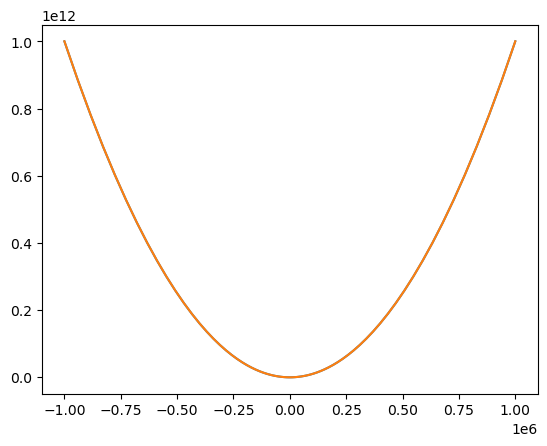

In [66]:
#####now on elliptic curves
# generally y*y = ax+b+x**3
x = np.linspace(-100,100,100)
y = (x**3+x+1)
plt.plot(x**3+x+1,y*y)
plt.plot(x**3,y*y)


In [70]:
##specifically we are using secp256k1 curve

#euqation is y*y = x**3 + 7 and it has nice matheatical properties.

from dataclasses import dataclass # dataclass is for creating custom classes in python

@dataclass
class Curve:
    
    p: int # prime modulo of finite field
    a: int 
    b: int
        
# secp256k1 uses a = 0, b = 7, so we're dealing with the curve y^2 = x^3 + 7 (mod p)

bitcoin_curve = Curve(
       p = 0xFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFEFFFFFC2F,
       a = 0x0000000000000000000000000000000000000000000000000000000000000000,
       b =   0x0000000000000000000000000000000000000000000000000000000000000007)
#above p is big prime number and constant for a = 0,b=7 in hexadecimals.

    



In [72]:
#generator point

@dataclass
class Point:
    #x,y on a curve
    curve: Curve
    x: int
    y: int


G = Point(bitcoin_curve,
         x = 0x79BE667EF9DCBBAC55A06295CE870B07029BFCDB2DCE28D959F2815B16F81798,
         y = 0x483ada7726a3c4655da4fbfc0e1108a8fd17b448a68554199c47d08ffb10d4b8,)
#above are also constants x and y 

In [74]:
#generator point is just a random point on curve 

if (G.y**2 - G.x**3 - 7) % bitcoin_curve.p == 0: #modular finite field
    print("it is")

it is


In [75]:
#order n is 0*G = n*G = INFINITY

@dataclass

class Generator:
    
    G:Point
    n: int
        
bitcoin_gen = Generator(G=G,
                       n = 0xFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFEBAAEDCE6AF48A03BBFD25E8CD0364141)


In [128]:
##secretkey/private key is just random integer from 1 to n where n is order of Generator Point.

bitcoin_gen.n 
# lets take a this4
secret_key = 22265090479312778178772228083027296664144

In [129]:
#public_key is G*(secret_key) times
#now Generator is Point and key is int so we have to define addition operator over curve

INF = Point(None, None, None) # special point at "infinity", kind of like a zero

def extended_euclidean_algorithm(a, b):
    """
    Returns (gcd, x, y) s.t. a * x + b * y == gcd
    This function implements the extended Euclidean
    algorithm and runs in O(log b) in the worst case,
    taken from Andrej Karpathy!.
    """
    old_r, r = a, b
    old_s, s = 1, 0
    old_t, t = 0, 1
    while r != 0:
        quotient = old_r // r
        old_r, r = r, old_r - quotient * r
        old_s, s = s, old_s - quotient * s
        old_t, t = t, old_t - quotient * t
    return old_r, old_s, old_t

def inv(n, p):
    """ returns modular multiplicate inverse m s.t. (n * m) % p == 1 """
    gcd, x, y = extended_euclidean_algorithm(n, p) # pylint: disable=unused-variable
    return x % p

def elliptic_curve_addition(self, other:Point) -> Point:
    if self == INF:
        return other
    if other == INF:
        return self
    
    # handle special case of P + (-P) = 0
    if self.x == other.x and self.y != other.y:
        return INF
    
    #otherwise slope
    
    if self.x == other.x:
        m = (3 * self.x**2 + self.curve.a) * inv(2 * self.y, self.curve.p)
        
    else:
        m = (self.y - other.y) * inv(self.x - other.x, self.curve.p)
    
    
      # compute the new point
    rx = (m**2 - self.x - other.x) % self.curve.p
    ry = (-(m*(rx - self.x) + self.y)) % self.curve.p
    return Point(self.curve, rx, ry)


        
    


In [130]:
# for python default add defines as __add__

print((7).__add__(9)) #16

#we define add method for point to curve addition

Point.__add__ = elliptic_curve_addition

16


In [132]:
#if secret key = 1 , public key =G
#if secret key = 2 , public key =G+G or 2G

#also secret_key should have to btw 1 and order n 
#and public key should have to be in curve.



In [113]:
print(G == 1*G)
print(G + G == 2*G)
print(G + G + G == 3*G)

True
True
True


In [133]:
def double_and_add(point:Point, k: int) -> Point:
    #assert isinstance(k, int) and k >= 0
    result = INF
    append = point
    while k:
        if k & 1:
            result += append
        append += append
        k >>= 1
    return result

# monkey patch double and add into the Point class for convenience
Point.__rmul__ = double_and_add

# "verify" correctness
print(G == 1*G)
print(G + G == 2*G)
print(G + G + G == 3*G)

True
True
True


In [169]:
public_key = secret_key*G

public_key.x,public_key.y


(83998262154709529558614902604110599582969848537757180553516367057821848015989,
 37676469766173670826348691885774454391218658108212372128812329274086400588247)

In [171]:
def gen_ripemd160_with_variable_scope_protector_to_not_pollute_global_namespace():

    import sys
    import struct

    # -----------------------------------------------------------------------------
    # public interface

    def ripemd160(b: bytes) -> bytes:
        """ simple wrapper for a simpler API to this hash function, just bytes to bytes """
        ctx = RMDContext()
        RMD160Update(ctx, b, len(b))
        digest = RMD160Final(ctx)
        return digest

    # -----------------------------------------------------------------------------

    class RMDContext:
        def __init__(self):
            self.state = [0x67452301, 0xEFCDAB89, 0x98BADCFE, 0x10325476, 0xC3D2E1F0] # uint32
            self.count = 0 # uint64
            self.buffer = [0]*64 # uchar

    def RMD160Update(ctx, inp, inplen):
        have = int((ctx.count // 8) % 64)
        inplen = int(inplen)
        need = 64 - have
        ctx.count += 8 * inplen
        off = 0
        if inplen >= need:
            if have:
                for i in range(need):
                    ctx.buffer[have+i] = inp[i]
                RMD160Transform(ctx.state, ctx.buffer)
                off = need
                have = 0
            while off + 64 <= inplen:
                RMD160Transform(ctx.state, inp[off:])
                off += 64
        if off < inplen:
            for i in range(inplen - off):
                ctx.buffer[have+i] = inp[off+i]

    def RMD160Final(ctx):
        size = struct.pack("<Q", ctx.count)
        padlen = 64 - ((ctx.count // 8) % 64)
        if padlen < 1 + 8:
            padlen += 64
        RMD160Update(ctx, PADDING, padlen-8)
        RMD160Update(ctx, size, 8)
        return struct.pack("<5L", *ctx.state)

    # -----------------------------------------------------------------------------

    K0 = 0x00000000
    K1 = 0x5A827999
    K2 = 0x6ED9EBA1
    K3 = 0x8F1BBCDC
    K4 = 0xA953FD4E
    KK0 = 0x50A28BE6
    KK1 = 0x5C4DD124
    KK2 = 0x6D703EF3
    KK3 = 0x7A6D76E9
    KK4 = 0x00000000

    PADDING = [0x80] + [0]*63

    def ROL(n, x):
        return ((x << n) & 0xffffffff) | (x >> (32 - n))

    def F0(x, y, z):
        return x ^ y ^ z

    def F1(x, y, z):
        return (x & y) | (((~x) % 0x100000000) & z)

    def F2(x, y, z):
        return (x | ((~y) % 0x100000000)) ^ z

    def F3(x, y, z):
        return (x & z) | (((~z) % 0x100000000) & y)

    def F4(x, y, z):
        return x ^ (y | ((~z) % 0x100000000))

    def R(a, b, c, d, e, Fj, Kj, sj, rj, X):
        a = ROL(sj, (a + Fj(b, c, d) + X[rj] + Kj) % 0x100000000) + e
        c = ROL(10, c)
        return a % 0x100000000, c

    def RMD160Transform(state, block): #uint32 state[5], uchar block[64]

        x = [0]*16
        assert sys.byteorder == 'little', "Only little endian is supported atm for RIPEMD160"
        x = struct.unpack('<16L', bytes(block[0:64]))

        a = state[0]
        b = state[1]
        c = state[2]
        d = state[3]
        e = state[4]

        #/* Round 1 */
        a, c = R(a, b, c, d, e, F0, K0, 11,  0, x)
        e, b = R(e, a, b, c, d, F0, K0, 14,  1, x)
        d, a = R(d, e, a, b, c, F0, K0, 15,  2, x)
        c, e = R(c, d, e, a, b, F0, K0, 12,  3, x)
        b, d = R(b, c, d, e, a, F0, K0,  5,  4, x)
        a, c = R(a, b, c, d, e, F0, K0,  8,  5, x)
        e, b = R(e, a, b, c, d, F0, K0,  7,  6, x)
        d, a = R(d, e, a, b, c, F0, K0,  9,  7, x)
        c, e = R(c, d, e, a, b, F0, K0, 11,  8, x)
        b, d = R(b, c, d, e, a, F0, K0, 13,  9, x)
        a, c = R(a, b, c, d, e, F0, K0, 14, 10, x)
        e, b = R(e, a, b, c, d, F0, K0, 15, 11, x)
        d, a = R(d, e, a, b, c, F0, K0,  6, 12, x)
        c, e = R(c, d, e, a, b, F0, K0,  7, 13, x)
        b, d = R(b, c, d, e, a, F0, K0,  9, 14, x)
        a, c = R(a, b, c, d, e, F0, K0,  8, 15, x) #/* #15 */
        #/* Round 2 */
        e, b = R(e, a, b, c, d, F1, K1,  7,  7, x)
        d, a = R(d, e, a, b, c, F1, K1,  6,  4, x)
        c, e = R(c, d, e, a, b, F1, K1,  8, 13, x)
        b, d = R(b, c, d, e, a, F1, K1, 13,  1, x)
        a, c = R(a, b, c, d, e, F1, K1, 11, 10, x)
        e, b = R(e, a, b, c, d, F1, K1,  9,  6, x)
        d, a = R(d, e, a, b, c, F1, K1,  7, 15, x)
        c, e = R(c, d, e, a, b, F1, K1, 15,  3, x)
        b, d = R(b, c, d, e, a, F1, K1,  7, 12, x)
        a, c = R(a, b, c, d, e, F1, K1, 12,  0, x)
        e, b = R(e, a, b, c, d, F1, K1, 15,  9, x)
        d, a = R(d, e, a, b, c, F1, K1,  9,  5, x)
        c, e = R(c, d, e, a, b, F1, K1, 11,  2, x)
        b, d = R(b, c, d, e, a, F1, K1,  7, 14, x)
        a, c = R(a, b, c, d, e, F1, K1, 13, 11, x)
        e, b = R(e, a, b, c, d, F1, K1, 12,  8, x) #/* #31 */
        #/* Round 3 */
        d, a = R(d, e, a, b, c, F2, K2, 11,  3, x)
        c, e = R(c, d, e, a, b, F2, K2, 13, 10, x)
        b, d = R(b, c, d, e, a, F2, K2,  6, 14, x)
        a, c = R(a, b, c, d, e, F2, K2,  7,  4, x)
        e, b = R(e, a, b, c, d, F2, K2, 14,  9, x)
        d, a = R(d, e, a, b, c, F2, K2,  9, 15, x)
        c, e = R(c, d, e, a, b, F2, K2, 13,  8, x)
        b, d = R(b, c, d, e, a, F2, K2, 15,  1, x)
        a, c = R(a, b, c, d, e, F2, K2, 14,  2, x)
        e, b = R(e, a, b, c, d, F2, K2,  8,  7, x)
        d, a = R(d, e, a, b, c, F2, K2, 13,  0, x)
        c, e = R(c, d, e, a, b, F2, K2,  6,  6, x)
        b, d = R(b, c, d, e, a, F2, K2,  5, 13, x)
        a, c = R(a, b, c, d, e, F2, K2, 12, 11, x)
        e, b = R(e, a, b, c, d, F2, K2,  7,  5, x)
        d, a = R(d, e, a, b, c, F2, K2,  5, 12, x) #/* #47 */
        #/* Round 4 */
        c, e = R(c, d, e, a, b, F3, K3, 11,  1, x)
        b, d = R(b, c, d, e, a, F3, K3, 12,  9, x)
        a, c = R(a, b, c, d, e, F3, K3, 14, 11, x)
        e, b = R(e, a, b, c, d, F3, K3, 15, 10, x)
        d, a = R(d, e, a, b, c, F3, K3, 14,  0, x)
        c, e = R(c, d, e, a, b, F3, K3, 15,  8, x)
        b, d = R(b, c, d, e, a, F3, K3,  9, 12, x)
        a, c = R(a, b, c, d, e, F3, K3,  8,  4, x)
        e, b = R(e, a, b, c, d, F3, K3,  9, 13, x)
        d, a = R(d, e, a, b, c, F3, K3, 14,  3, x)
        c, e = R(c, d, e, a, b, F3, K3,  5,  7, x)
        b, d = R(b, c, d, e, a, F3, K3,  6, 15, x)
        a, c = R(a, b, c, d, e, F3, K3,  8, 14, x)
        e, b = R(e, a, b, c, d, F3, K3,  6,  5, x)
        d, a = R(d, e, a, b, c, F3, K3,  5,  6, x)
        c, e = R(c, d, e, a, b, F3, K3, 12,  2, x) #/* #63 */
        #/* Round 5 */
        b, d = R(b, c, d, e, a, F4, K4,  9,  4, x)
        a, c = R(a, b, c, d, e, F4, K4, 15,  0, x)
        e, b = R(e, a, b, c, d, F4, K4,  5,  5, x)
        d, a = R(d, e, a, b, c, F4, K4, 11,  9, x)
        c, e = R(c, d, e, a, b, F4, K4,  6,  7, x)
        b, d = R(b, c, d, e, a, F4, K4,  8, 12, x)
        a, c = R(a, b, c, d, e, F4, K4, 13,  2, x)
        e, b = R(e, a, b, c, d, F4, K4, 12, 10, x)
        d, a = R(d, e, a, b, c, F4, K4,  5, 14, x)
        c, e = R(c, d, e, a, b, F4, K4, 12,  1, x)
        b, d = R(b, c, d, e, a, F4, K4, 13,  3, x)
        a, c = R(a, b, c, d, e, F4, K4, 14,  8, x)
        e, b = R(e, a, b, c, d, F4, K4, 11, 11, x)
        d, a = R(d, e, a, b, c, F4, K4,  8,  6, x)
        c, e = R(c, d, e, a, b, F4, K4,  5, 15, x)
        b, d = R(b, c, d, e, a, F4, K4,  6, 13, x) #/* #79 */

        aa = a
        bb = b
        cc = c
        dd = d
        ee = e

        a = state[0]
        b = state[1]
        c = state[2]
        d = state[3]
        e = state[4]

        #/* Parallel round 1 */
        a, c = R(a, b, c, d, e, F4, KK0,  8,  5, x)
        e, b = R(e, a, b, c, d, F4, KK0,  9, 14, x)
        d, a = R(d, e, a, b, c, F4, KK0,  9,  7, x)
        c, e = R(c, d, e, a, b, F4, KK0, 11,  0, x)
        b, d = R(b, c, d, e, a, F4, KK0, 13,  9, x)
        a, c = R(a, b, c, d, e, F4, KK0, 15,  2, x)
        e, b = R(e, a, b, c, d, F4, KK0, 15, 11, x)
        d, a = R(d, e, a, b, c, F4, KK0,  5,  4, x)
        c, e = R(c, d, e, a, b, F4, KK0,  7, 13, x)
        b, d = R(b, c, d, e, a, F4, KK0,  7,  6, x)
        a, c = R(a, b, c, d, e, F4, KK0,  8, 15, x)
        e, b = R(e, a, b, c, d, F4, KK0, 11,  8, x)
        d, a = R(d, e, a, b, c, F4, KK0, 14,  1, x)
        c, e = R(c, d, e, a, b, F4, KK0, 14, 10, x)
        b, d = R(b, c, d, e, a, F4, KK0, 12,  3, x)
        a, c = R(a, b, c, d, e, F4, KK0,  6, 12, x) #/* #15 */
        #/* Parallel round 2 */
        e, b = R(e, a, b, c, d, F3, KK1,  9,  6, x)
        d, a = R(d, e, a, b, c, F3, KK1, 13, 11, x)
        c, e = R(c, d, e, a, b, F3, KK1, 15,  3, x)
        b, d = R(b, c, d, e, a, F3, KK1,  7,  7, x)
        a, c = R(a, b, c, d, e, F3, KK1, 12,  0, x)
        e, b = R(e, a, b, c, d, F3, KK1,  8, 13, x)
        d, a = R(d, e, a, b, c, F3, KK1,  9,  5, x)
        c, e = R(c, d, e, a, b, F3, KK1, 11, 10, x)
        b, d = R(b, c, d, e, a, F3, KK1,  7, 14, x)
        a, c = R(a, b, c, d, e, F3, KK1,  7, 15, x)
        e, b = R(e, a, b, c, d, F3, KK1, 12,  8, x)
        d, a = R(d, e, a, b, c, F3, KK1,  7, 12, x)
        c, e = R(c, d, e, a, b, F3, KK1,  6,  4, x)
        b, d = R(b, c, d, e, a, F3, KK1, 15,  9, x)
        a, c = R(a, b, c, d, e, F3, KK1, 13,  1, x)
        e, b = R(e, a, b, c, d, F3, KK1, 11,  2, x) #/* #31 */
        #/* Parallel round 3 */
        d, a = R(d, e, a, b, c, F2, KK2,  9, 15, x)
        c, e = R(c, d, e, a, b, F2, KK2,  7,  5, x)
        b, d = R(b, c, d, e, a, F2, KK2, 15,  1, x)
        a, c = R(a, b, c, d, e, F2, KK2, 11,  3, x)
        e, b = R(e, a, b, c, d, F2, KK2,  8,  7, x)
        d, a = R(d, e, a, b, c, F2, KK2,  6, 14, x)
        c, e = R(c, d, e, a, b, F2, KK2,  6,  6, x)
        b, d = R(b, c, d, e, a, F2, KK2, 14,  9, x)
        a, c = R(a, b, c, d, e, F2, KK2, 12, 11, x)
        e, b = R(e, a, b, c, d, F2, KK2, 13,  8, x)
        d, a = R(d, e, a, b, c, F2, KK2,  5, 12, x)
        c, e = R(c, d, e, a, b, F2, KK2, 14,  2, x)
        b, d = R(b, c, d, e, a, F2, KK2, 13, 10, x)
        a, c = R(a, b, c, d, e, F2, KK2, 13,  0, x)
        e, b = R(e, a, b, c, d, F2, KK2,  7,  4, x)
        d, a = R(d, e, a, b, c, F2, KK2,  5, 13, x) #/* #47 */
        #/* Parallel round 4 */
        c, e = R(c, d, e, a, b, F1, KK3, 15,  8, x)
        b, d = R(b, c, d, e, a, F1, KK3,  5,  6, x)
        a, c = R(a, b, c, d, e, F1, KK3,  8,  4, x)
        e, b = R(e, a, b, c, d, F1, KK3, 11,  1, x)
        d, a = R(d, e, a, b, c, F1, KK3, 14,  3, x)
        c, e = R(c, d, e, a, b, F1, KK3, 14, 11, x)
        b, d = R(b, c, d, e, a, F1, KK3,  6, 15, x)
        a, c = R(a, b, c, d, e, F1, KK3, 14,  0, x)
        e, b = R(e, a, b, c, d, F1, KK3,  6,  5, x)
        d, a = R(d, e, a, b, c, F1, KK3,  9, 12, x)
        c, e = R(c, d, e, a, b, F1, KK3, 12,  2, x)
        b, d = R(b, c, d, e, a, F1, KK3,  9, 13, x)
        a, c = R(a, b, c, d, e, F1, KK3, 12,  9, x)
        e, b = R(e, a, b, c, d, F1, KK3,  5,  7, x)
        d, a = R(d, e, a, b, c, F1, KK3, 15, 10, x)
        c, e = R(c, d, e, a, b, F1, KK3,  8, 14, x) #/* #63 */
        #/* Parallel round 5 */
        b, d = R(b, c, d, e, a, F0, KK4,  8, 12, x)
        a, c = R(a, b, c, d, e, F0, KK4,  5, 15, x)
        e, b = R(e, a, b, c, d, F0, KK4, 12, 10, x)
        d, a = R(d, e, a, b, c, F0, KK4,  9,  4, x)
        c, e = R(c, d, e, a, b, F0, KK4, 12,  1, x)
        b, d = R(b, c, d, e, a, F0, KK4,  5,  5, x)
        a, c = R(a, b, c, d, e, F0, KK4, 14,  8, x)
        e, b = R(e, a, b, c, d, F0, KK4,  6,  7, x)
        d, a = R(d, e, a, b, c, F0, KK4,  8,  6, x)
        c, e = R(c, d, e, a, b, F0, KK4, 13,  2, x)
        b, d = R(b, c, d, e, a, F0, KK4,  6, 13, x)
        a, c = R(a, b, c, d, e, F0, KK4,  5, 14, x)
        e, b = R(e, a, b, c, d, F0, KK4, 15,  0, x)
        d, a = R(d, e, a, b, c, F0, KK4, 13,  3, x)
        c, e = R(c, d, e, a, b, F0, KK4, 11,  9, x)
        b, d = R(b, c, d, e, a, F0, KK4, 11, 11, x) #/* #79 */

        t = (state[1] + cc + d) % 0x100000000
        state[1] = (state[2] + dd + e) % 0x100000000
        state[2] = (state[3] + ee + a) % 0x100000000
        state[3] = (state[4] + aa + b) % 0x100000000
        state[4] = (state[0] + bb + c) % 0x100000000
        state[0] = t % 0x100000000

    return ripemd160

In [172]:
def gen_sha256_with_variable_scope_protector_to_not_pollute_global_namespace():

    """
    SHA256 implementation.

    Follows the FIPS PUB 180-4 description for calculating SHA-256 hash function
    https://nvlpubs.nist.gov/nistpubs/FIPS/NIST.FIPS.180-4.pdf

    Noone in their right mind should use this for any serious reason. This was written
    purely for educational purposes.
    """

    import math
    from itertools import count, islice

    # -----------------------------------------------------------------------------
    # SHA-256 Functions, defined in Section 4

    def rotr(x, n, size=32):
        return (x >> n) | (x << size - n) & (2**size - 1)

    def shr(x, n):
        return x >> n

    def sig0(x):
        return rotr(x, 7) ^ rotr(x, 18) ^ shr(x, 3)

    def sig1(x):
        return rotr(x, 17) ^ rotr(x, 19) ^ shr(x, 10)

    def capsig0(x):
        return rotr(x, 2) ^ rotr(x, 13) ^ rotr(x, 22)

    def capsig1(x):
        return rotr(x, 6) ^ rotr(x, 11) ^ rotr(x, 25)

    def ch(x, y, z):
        return (x & y)^ (~x & z)

    def maj(x, y, z):
        return (x & y) ^ (x & z) ^ (y & z)

    def b2i(b):
        return int.from_bytes(b, 'big')

    def i2b(i):
        return i.to_bytes(4, 'big')

    # -----------------------------------------------------------------------------
    # SHA-256 Constants

    def is_prime(n):
        return not any(f for f in range(2,int(math.sqrt(n))+1) if n%f == 0)

    def first_n_primes(n):
        return islice(filter(is_prime, count(start=2)), n)

    def frac_bin(f, n=32):
        """ return the first n bits of fractional part of float f """
        f -= math.floor(f) # get only the fractional part
        f *= 2**n # shift left
        f = int(f) # truncate the rest of the fractional content
        return f

    def genK():
        """
        Follows Section 4.2.2 to generate K

        The first 32 bits of the fractional parts of the cube roots of the first
        64 prime numbers:

        428a2f98 71374491 b5c0fbcf e9b5dba5 3956c25b 59f111f1 923f82a4 ab1c5ed5
        d807aa98 12835b01 243185be 550c7dc3 72be5d74 80deb1fe 9bdc06a7 c19bf174
        e49b69c1 efbe4786 0fc19dc6 240ca1cc 2de92c6f 4a7484aa 5cb0a9dc 76f988da
        983e5152 a831c66d b00327c8 bf597fc7 c6e00bf3 d5a79147 06ca6351 14292967
        27b70a85 2e1b2138 4d2c6dfc 53380d13 650a7354 766a0abb 81c2c92e 92722c85
        a2bfe8a1 a81a664b c24b8b70 c76c51a3 d192e819 d6990624 f40e3585 106aa070
        19a4c116 1e376c08 2748774c 34b0bcb5 391c0cb3 4ed8aa4a 5b9cca4f 682e6ff3
        748f82ee 78a5636f 84c87814 8cc70208 90befffa a4506ceb bef9a3f7 c67178f2
        """
        return [frac_bin(p ** (1/3.0)) for p in first_n_primes(64)]

    def genH():
        """
        Follows Section 5.3.3 to generate the initial hash value H^0

        The first 32 bits of the fractional parts of the square roots of
        the first 8 prime numbers.

        6a09e667 bb67ae85 3c6ef372 a54ff53a 9b05688c 510e527f 1f83d9ab 5be0cd19
        """
        return [frac_bin(p ** (1/2.0)) for p in first_n_primes(8)]

    # -----------------------------------------------------------------------------

    def pad(b):
        """ Follows Section 5.1: Padding the message """
        b = bytearray(b) # convert to a mutable equivalent
        l = len(b) * 8 # note: len returns number of bytes not bits

        # append but "1" to the end of the message
        b.append(0b10000000) # appending 10000000 in binary (=128 in decimal)

        # follow by k zero bits, where k is the smallest non-negative solution to
        # l + 1 + k = 448 mod 512
        # i.e. pad with zeros until we reach 448 (mod 512)
        while (len(b)*8) % 512 != 448:
            b.append(0x00)

        # the last 64-bit block is the length l of the original message
        # expressed in binary (big endian)
        b.extend(l.to_bytes(8, 'big'))

        return b

    def sha256(b: bytes) -> bytes:

        # Section 4.2
        K = genK()

        # Section 5: Preprocessing
        # Section 5.1: Pad the message
        b = pad(b)
        # Section 5.2: Separate the message into blocks of 512 bits (64 bytes)
        blocks = [b[i:i+64] for i in range(0, len(b), 64)]

        # for each message block M^1 ... M^N
        H = genH() # Section 5.3

        # Section 6
        for M in blocks: # each block is a 64-entry array of 8-bit bytes

            # 1. Prepare the message schedule, a 64-entry array of 32-bit words
            W = []
            for t in range(64):
                if t <= 15:
                    # the first 16 words are just a copy of the block
                    W.append(bytes(M[t*4:t*4+4]))
                else:
                    term1 = sig1(b2i(W[t-2]))
                    term2 = b2i(W[t-7])
                    term3 = sig0(b2i(W[t-15]))
                    term4 = b2i(W[t-16])
                    total = (term1 + term2 + term3 + term4) % 2**32
                    W.append(i2b(total))

            # 2. Initialize the 8 working variables a,b,c,d,e,f,g,h with prev hash value
            a, b, c, d, e, f, g, h = H

            # 3.
            for t in range(64):
                T1 = (h + capsig1(e) + ch(e, f, g) + K[t] + b2i(W[t])) % 2**32
                T2 = (capsig0(a) + maj(a, b, c)) % 2**32
                h = g
                g = f
                f = e
                e = (d + T1) % 2**32
                d = c
                c = b
                b = a
                a = (T1 + T2) % 2**32

            # 4. Compute the i-th intermediate hash value H^i
            delta = [a, b, c, d, e, f, g, h]
            H = [(i1 + i2) % 2**32 for i1, i2 in zip(H, delta)]

        return b''.join(i2b(i) for i in H)

    return sha256

In [182]:
ripemd160 = gen_ripemd160_with_variable_scope_protector_to_not_pollute_global_namespace()
print(ripemd160(b'hello this is a test').hex())
print("number of bytes in a RIPEMD-160 digest: ", len(ripemd160(b'')))

sha256 = gen_sha256_with_variable_scope_protector_to_not_pollute_global_namespace()
print("verify empty hash:", sha256(b'').hex())

f51960af7dd4813a587ab26388ddab3b28d1f7b4
number of bytes in a RIPEMD-160 digest:  20
verify empty hash: e3b0c44298fc1c149afbf4c8996fb92427ae41e4649b934ca495991b7852b855


In [170]:
import hashlib ##generating sha256 

##thanks CHATGPT


import hashlib

def sha256_gpt(string):
    # Encode the string to bytes
    string_bytes = string.encode()
    
    # Create the hash object
    hash_object = hashlib.sha256()
    
    # Update the hash object with the string bytes
    hash_object.update(string_bytes)
    
    # Get the hexadecimal representation of the hash
    hash_hex = hash_object.hexdigest()
    
    return hash_hex

def ripemd160_gpt(string):
    # Encode the string to bytes
    string_bytes = string.encode()
    
    # Create the hash object
    hash_object = hashlib.new('ripemd160')
    
    # Update the hash object with the string bytes
    hash_object.update(string_bytes)
    
    # Get the hexadecimal representation of the hash
    hash_hex = hash_object.hexdigest()
    
    return hash_hex





In [183]:
class PublicKey(Point):
    ##its a point on the curve
    ##with additional functionalities
    
    @classmethod
    def from_point(cls,pt):
        return cls(pt.curve,pt.x,pt.y)
    
    def encode(self, compressed, hash160=False):
        if compressed:
            # (x,y) is very redundant. Because y^2 = x^3 + 7,
            # we can just encode x, and then y = +/- sqrt(x^3 + 7),
            # so we need one more bit to encode whether it was the + or the -
            # but because this is modular arithmetic there is no +/-, instead
            # it can be shown that one y will always be even and the other odd.
            prefix = b'\x02' if self.y % 2 == 0 else b'\x03'
            pkb = prefix + self.x.to_bytes(32, 'big')
        else:
            pkb = b'\x04' + self.x.to_bytes(32, 'big') + self.y.to_bytes(32, 'big')
        # hash if desired
        return ripemd160(sha256(pkb)) if hash160 else pkb
    
    def address(self, net: str, compressed: bool) -> str:
        """ return the associated bitcoin address for this public key as string """
        # encode the public key into bytes and hash to get the payload
        pkb_hash = self.encode(compressed=compressed, hash160=True)
        # add version byte (0x00 for Main Network, or 0x6f for Test Network)
        version = {'main': b'\x00', 'test': b'\x6f'}
        ver_pkb_hash = version[net] + pkb_hash
        # calculate the checksum
        checksum = sha256(sha256(ver_pkb_hash))[:4]
        # append to form the full 25-byte binary Bitcoin Address
        byte_address = ver_pkb_hash + checksum
        # finally b58 encode the result
        b58check_address = b58encode(byte_address)
        return b58check_address
   

    

        
    
    

In [184]:
alphabet = '123456789ABCDEFGHJKLMNPQRSTUVWXYZabcdefghijkmnopqrstuvwxyz'

def b58encode(b: bytes) -> str:
    assert len(b) == 25 # version is 1 byte, pkb_hash 20 bytes, checksum 4 bytes
    n = int.from_bytes(b, 'big')
    chars = []
    while n:
        n, i = divmod(n, 58)
        chars.append(alphabet[i])
    # special case handle the leading 0 bytes... ¯\_(ツ)_/¯
    num_leading_zeros = len(b) - len(b.lstrip(b'\x00'))
    res = num_leading_zeros * alphabet[0] + ''.join(reversed(chars))
    return res

In [185]:
address = PublicKey.from_point(public_key).address(net='test', compressed=True)
print(address)
##here from generating predefined hashmap functions generates error due to differernt
#sha256 , so we can once again do what karpathy did

mnNcaVkC35ezZSgvn8fhXEa9QTHSUtPfzQ


In [187]:
##3thats it go to https://www.blockchain.com/btc-testnet/address/mnNcaVkC35ezZSgvn8fhXEa9QTHSUtPfzQ
##we have $0.00 BTC.

#but if we use common secret key like 1

# there will be many transactions and if we fing balance what would be cooler than that.


new_sk = 1
new_pk  = (new_sk)*G

address = PublicKey.from_point(new_pk).address(net='test',compressed=True)
address

'mrCDrCybB6J1vRfbwM5hemdJz73FwDBC8r'

In [188]:
##check it on blockchain 

In [198]:
##here are the things we gwnwrated

print("secret key:",secret_key)  # random integer from 1 to order
print("public_key", (public_key.x,public_key.y)) ## pk*Generator 
print("bitcoin address",address) ##with lot of things sha256 and ripemd160 and things i dont explain it yet.


secret key: 22265090479312778178772228083027296664144
public_key (83998262154709529558614902604110599582969848537757180553516367057821848015989, 37676469766173670826348691885774454391218658108212372128812329274086400588247)
bitcoin address mrCDrCybB6J1vRfbwM5hemdJz73FwDBC8r


In [190]:
bitcoin_gen.n

115792089237316195423570985008687907852837564279074904382605163141518161494337

In [206]:
###now we should send transactions.

#again for 2

secret_key2 = 9420694206942069420 # it should be between 1 and bitcoin_gen.n 
public_key2 = secret_key2*G
address2 = PublicKey.from_point(public_key2).address(net='test',compressed=True)

print("sk2:",secret_key2)
print("pk2:",public_key2)
print("address2:",address2)

sk2: 9420694206942069420
pk2: Point(curve=Curve(p=115792089237316195423570985008687907853269984665640564039457584007908834671663, a=0, b=7), x=1931940939439244830425264748186596357684278289767219150324625815320455868315, y=55915680869027623923563737236421892002681583500633903760576499241014681151341)
address2: mueRd6kZjt2VeYKA4LfFJ428QsdqrDkfMd


In [ ]:
## next we would send transaction

